In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3090


In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [3]:
!ls /content/drive/MyDrive/kaggle/input

ls: cannot access '/content/drive/MyDrive/kaggle/input': No such file or directory


'dx' is short for diagnosis (for the patient)
- 'nv': 'Melanocytic nevi'
- 'mel': 'Melanoma'
- 'bkl': 'Benign keratosis-like lesions'
- 'bcc': 'Basal cell carcinoma'
- 'akiec': 'Actinic keratoses'
- 'vasc': 'Vascular lesions'
- 'df': 'Dermatofibroma'

'dx_type' is how the diagnosis was made. 
- histo        5340
- follow_up    3704
- consensus     902
- confocal       69

In [4]:
# import pandas as pd

# # labels_path = "../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
# labels_path = "/content/drive/MyDrive/kaggle/input/HAM10000_metadata.csv"
# image_labels_df = pd.read_csv(labels_path)
# image_labels_df.head()

In [5]:
# image_labels_df.sort_values(by="image_id")

In [6]:
# type(image_labels_df["image_id"][0])


In [7]:
import pandas as pd
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def disease_to_label(l):
    if l == "akiec":
        return 0
    if l == "bcc":
        return 1
    if l == "bkl":
        return 2
    if l == "df":
        return 3
    if l == "mel":
        return 4
    if l == "nv":
        return 5
    if l == "vasc":
        return 6 

class SkinCancerDetection_train(Dataset):
    
    def __init__(self, train_path, csv, transform=None):
        self.train_path = train_path
        self.csv_path = csv
        self.transform = transform
    def __len__(self):
        df = pd.read_csv(self.csv_path)
        return (len(df.index))
    def __getitem__(self, idx):
        image_id = "ISIC_00" + str(idx+27306)
        image_file_name = image_id + ".jpg"
        df = pd.read_csv(self.csv_path)
        label = disease_to_label(str(df.loc[df['image_id'] == image_id, 'dx'].item()))
        p = os.path.join(self.train_path, image_file_name)

        img = plt.imread(p)


        if self.transform:
            img = self.transform(img)
        
        return img, label
    
class SkinCancerDetection_test(Dataset):
    
    def __init__(self, test_path, csv, transform=None):
        self.test_path = test_path
        self.csv_path = csv
        self.transform = transform
    def __len__(self):
        df = pd.read_csv(self.csv_path)
        return (len(df.index))
    def __getitem__(self, idx):
        image_id = "ISIC_00" + str(idx+24306)
        image_file_name = image_id + ".jpg"
        df = pd.read_csv(self.csv_path)
        label = disease_to_label(str(df.loc[df['image_id'] == image_id, 'dx'].item()))
        
        p = os.path.join(self.test_path, image_file_name)
        
        img = plt.imread(p)
            
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [8]:
import timm
train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.25),
#             transforms.Resize(256),
#             transforms.CenterCrop(224),
            transforms.Resize((32,32)),
            transforms.ToTensor(),
            transforms.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
            transforms.RandomErasing(p=0.1, value='random')
        ])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD) # imagenet means
])

train_ds = SkinCancerDetection_train('../../kaggle/input/HAM10000_images_train','../../kaggle/input/HAM10000_metadata_train.csv',transform=train_transform)
val_ds = SkinCancerDetection_test('../../kaggle/input/HAM10000_images_test','../../kaggle/input/HAM10000_metadata_test.csv',transform=test_transform)

In [9]:
# import pandas as pd
# import os
# idx = 0
# image_id = "ISIC_00" + str(idx+24306)
# image_file_name = image_id + ".jpg"
# # df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
# df = pd.read_csv('/content/drive/MyDrive/kaggle/input/HAM10000_metadata.csv')
# label = disease_to_label(str(df.loc[df['image_id'] == image_id, 'dx'].item()))
# # p1 = os.path.join('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1', image_file_name)
# # p2 = os.path.join('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2', image_file_name)
# p1 = os.path.join('/content/drive/MyDrive/kaggle/input/HAM10000_images_part_1', image_file_name)
# p2 = os.path.join('/content/drive/MyDrive/kaggle/input/HAM10000_images_part_2', image_file_name)
# if os.path.isfile(p1):
#     img = plt.imread(p1)
# if os.path.isfile(p2):
#     img = plt.imread(p2)
# transform = transforms.ToTensor()
# img = transform(img)
# transform = transforms.Resize((30, 40))
# img = transform(img)

# img.shape
# plt.figure()
# plt.imshow(img.permute(1, 2, 0))

In [10]:
len(train_ds)

7015

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


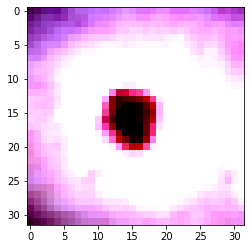

tensor(5)


In [11]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 42
torch.manual_seed(random_seed)

batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

plt.figure()

for image, label in train_dl:
    plt.imshow(image[0].permute(2, 1, 0))
    print(type(image[0]))
    plt.show()
    print(label[0])
    break

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [13]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        
    #     ------------------- calculate fscore for each batch ----------------

        _, y_preds = torch.max(out, dim=1)    
        threeMetrics = precision_recall_fscore_support(torch.Tensor.cpu(labels), torch.Tensor.cpu(y_preds), average=None,labels=[i for i in range(7)])
        fscore = torch.tensor(threeMetrics[2]) # fscore (return a tensor of a list: tensor([1,2,3]))

        return {'val_loss': loss.detach(), 'val_acc': acc, 'val_fscore': fscore}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        batch_fscores = [x['val_fscore'] for x in outputs] 
        epoch_fscore = torch.stack(batch_fscores).mean(0)  # Calculate mean fscore
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(), 'val_fscore': epoch_fscore.tolist()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, val_fscore: {}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc'], result['val_fscore']))

In [14]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [15]:
model = to_device(ResNet9(3, 7), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [18]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.9769690036773682,
  'val_acc': 0.01515794824808836,
  'val_fscore': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.029786391505721627]}]

In [19]:
epochs = 4
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [20]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00934, train_loss: 1.1066, val_loss: 1.6070, val_acc: 0.7019, val_fscore: [0.0, 0.06594516594516595, 0.24374015274139038, 0.0, 0.1847865275793326, 0.836313307217503, 0.0]
Epoch [1], last_lr: 0.00812, train_loss: 0.9230, val_loss: 0.9416, val_acc: 0.7240, val_fscore: [0.048005698005698004, 0.036904761904761905, 0.41148501833273543, 0.0, 0.3268803200672792, 0.8705132194595393, 0.0]
Epoch [2], last_lr: 0.00283, train_loss: 0.7994, val_loss: 0.7587, val_acc: 0.7115, val_fscore: [0.1896649374590551, 0.4076036540619874, 0.4676576087880518, 0.0, 0.43192941797214685, 0.8651642068809458, 0.3742063492063492]
Epoch [3], last_lr: 0.00000, train_loss: 0.7401, val_loss: 0.6731, val_acc: 0.7599, val_fscore: [0.3056830961436225, 0.441457660480502, 0.43099953145867104, 0.0, 0.310644621451078, 0.8914560767330265, 0.7119631185807656]
CPU times: user 2.25 s, sys: 578 ms, total: 2.83 s
Wall time: 3min 58s


In [21]:
epochs = 4
max_lr = 0.005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00467, train_loss: 0.7755, val_loss: 4.8351, val_acc: 0.6449, val_fscore: [0.0, 0.0, 0.030943847072879328, 0.0, 0.16378192767879318, 0.8084895457708964, 0.05555555555555555]
Epoch [1], last_lr: 0.00406, train_loss: 0.8361, val_loss: 0.7031, val_acc: 0.7486, val_fscore: [0.016666666666666666, 0.3681332629358945, 0.46541620793894173, 0.0, 0.26103049686967406, 0.884458181859614, 0.5810515873015873]
Epoch [2], last_lr: 0.00142, train_loss: 0.7518, val_loss: 0.6628, val_acc: 0.7578, val_fscore: [0.2727450980392157, 0.47141116292992563, 0.3726205987186206, 0.0, 0.31653105641210855, 0.886633495394291, 0.6492724867724867]
Epoch [3], last_lr: 0.00000, train_loss: 0.6812, val_loss: 0.6267, val_acc: 0.7662, val_fscore: [0.3377609862903981, 0.5164970323571929, 0.45220605004281245, 0.0, 0.3563298067291785, 0.8926750783487288, 0.7605742296918767]


In [22]:
epochs = 4
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-3
opt_func = torch.optim.Adam

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00093, train_loss: 0.6761, val_loss: 0.6393, val_acc: 0.7647, val_fscore: [0.3186716610192179, 0.4864558978398809, 0.4110146622615281, 0.0, 0.27257038010552387, 0.8917467686851291, 0.6862103174603175]
Epoch [1], last_lr: 0.00081, train_loss: 0.6939, val_loss: 0.6315, val_acc: 0.7704, val_fscore: [0.15232683982683984, 0.5128822965635109, 0.4887566431526138, 0.0, 0.35715556057011094, 0.8984978729663015, 0.6197089947089948]
Epoch [2], last_lr: 0.00028, train_loss: 0.6721, val_loss: 0.6331, val_acc: 0.7702, val_fscore: [0.11673881673881674, 0.4894625249835807, 0.4303247776652032, 0.0, 0.4098775755473642, 0.897094364923095, 0.7235780423280422]
Epoch [3], last_lr: 0.00000, train_loss: 0.6382, val_loss: 0.6022, val_acc: 0.7828, val_fscore: [0.431846429265833, 0.5379500085919865, 0.5002656564284772, 0.09722222222222221, 0.38491046554257885, 0.9007400145610361, 0.7644812789549631]


In [23]:
epochs = 4
max_lr = 0.00001
grad_clip = 0.1
weight_decay = 1e-3
opt_func = torch.optim.Adam

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00001, train_loss: 0.6257, val_loss: 0.6020, val_acc: 0.7823, val_fscore: [0.42691357132146607, 0.5258514147134737, 0.5037130149040313, 0.09722222222222221, 0.3679707027785726, 0.9018174494770005, 0.7714257233994076]
Epoch [1], last_lr: 0.00001, train_loss: 0.6239, val_loss: 0.6007, val_acc: 0.7798, val_fscore: [0.4065540294945329, 0.5219190662801849, 0.5045229608323446, 0.041666666666666664, 0.3624516383226777, 0.8994995358232635, 0.7788331308068149]
Epoch [2], last_lr: 0.00000, train_loss: 0.6175, val_loss: 0.6016, val_acc: 0.7807, val_fscore: [0.40564508194875676, 0.5132995567012594, 0.5082873787659422, 0.041666666666666664, 0.37027124768387915, 0.9016994181079462, 0.7788331308068149]
Epoch [3], last_lr: 0.00000, train_loss: 0.6180, val_loss: 0.6001, val_acc: 0.7791, val_fscore: [0.3913011905460418, 0.5207984374586542, 0.5039499543892774, 0.041666666666666664, 0.37449106115406244, 0.9010527909403047, 0.7788331308068149]


In [24]:
torch.save(model.state_dict(), '../../kaggle/ubuntu_save_model/ubuntu_resnet9.pth')

In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

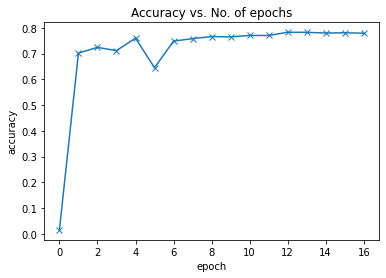

In [26]:
plot_accuracies(history)

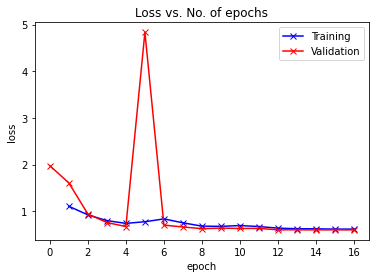

In [27]:
plot_losses(history)